Using device: cpu
Synthetic data generated: 600 points
Data shape - x: (600,), t: (600,), u: (600,)
Starting training with curriculum learning...
Epoch 500: Increasing PDE weight to 0.020
Epoch 1000: Increasing PDE weight to 0.030
Epoch 1000/15000 | Total: 1.37e-01 | Data: 7.18e-03 | PDE: 6.35e-01 | BC: 4.69e-03 | IC: 1.27e-02
Epoch 1500: Increasing PDE weight to 0.040
Epoch 2000: Increasing PDE weight to 0.050
Epoch 2000/15000 | Total: 8.69e-02 | Data: 6.11e-03 | PDE: 2.96e-01 | BC: 3.59e-03 | IC: 6.04e-03
Epoch 2500: Increasing PDE weight to 0.060
Epoch 3000: Increasing PDE weight to 0.070
Epoch 3000/15000 | Total: 5.97e-02 | Data: 4.20e-03 | PDE: 7.61e-02 | BC: 2.95e-03 | IC: 4.13e-03
Epoch 3500: Increasing PDE weight to 0.080
Epoch 4000: Increasing PDE weight to 0.090
Epoch 4000/15000 | Total: 5.64e-02 | Data: 3.04e-03 | PDE: 5.31e-02 | BC: 2.15e-03 | IC: 5.42e-03
Epoch 4500: Increasing PDE weight to 0.100
Epoch 5000: Increasing PDE weight to 0.110
Epoch 5000/15000 | Total: 4.69e-0

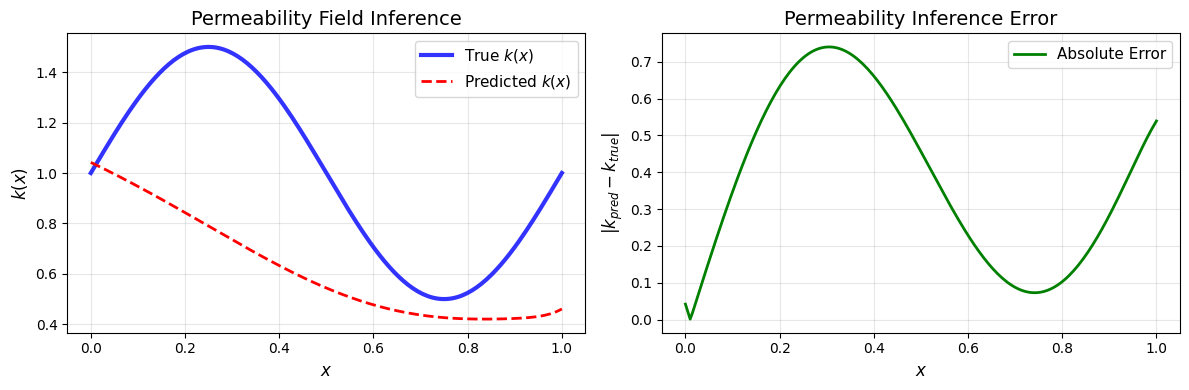

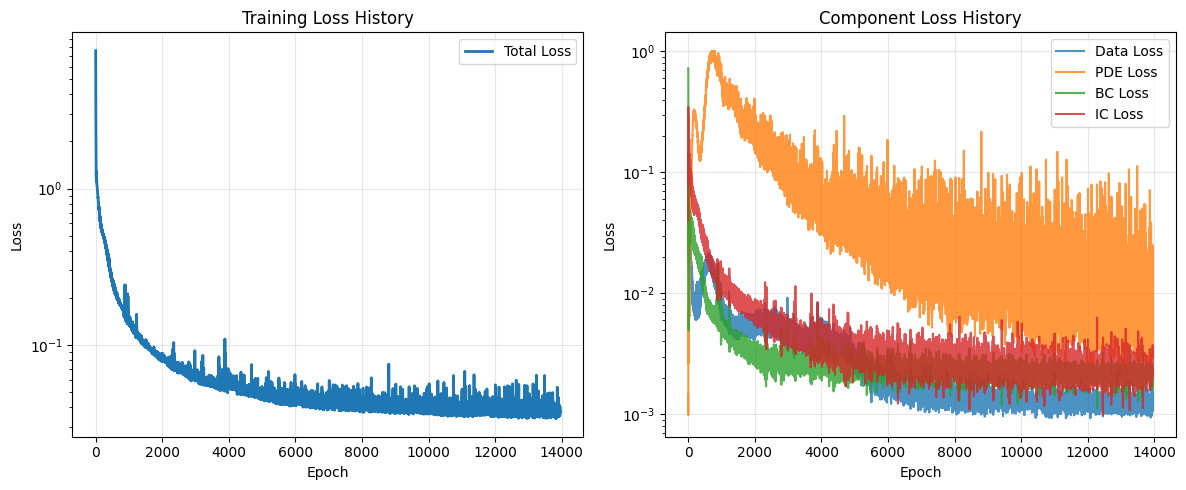

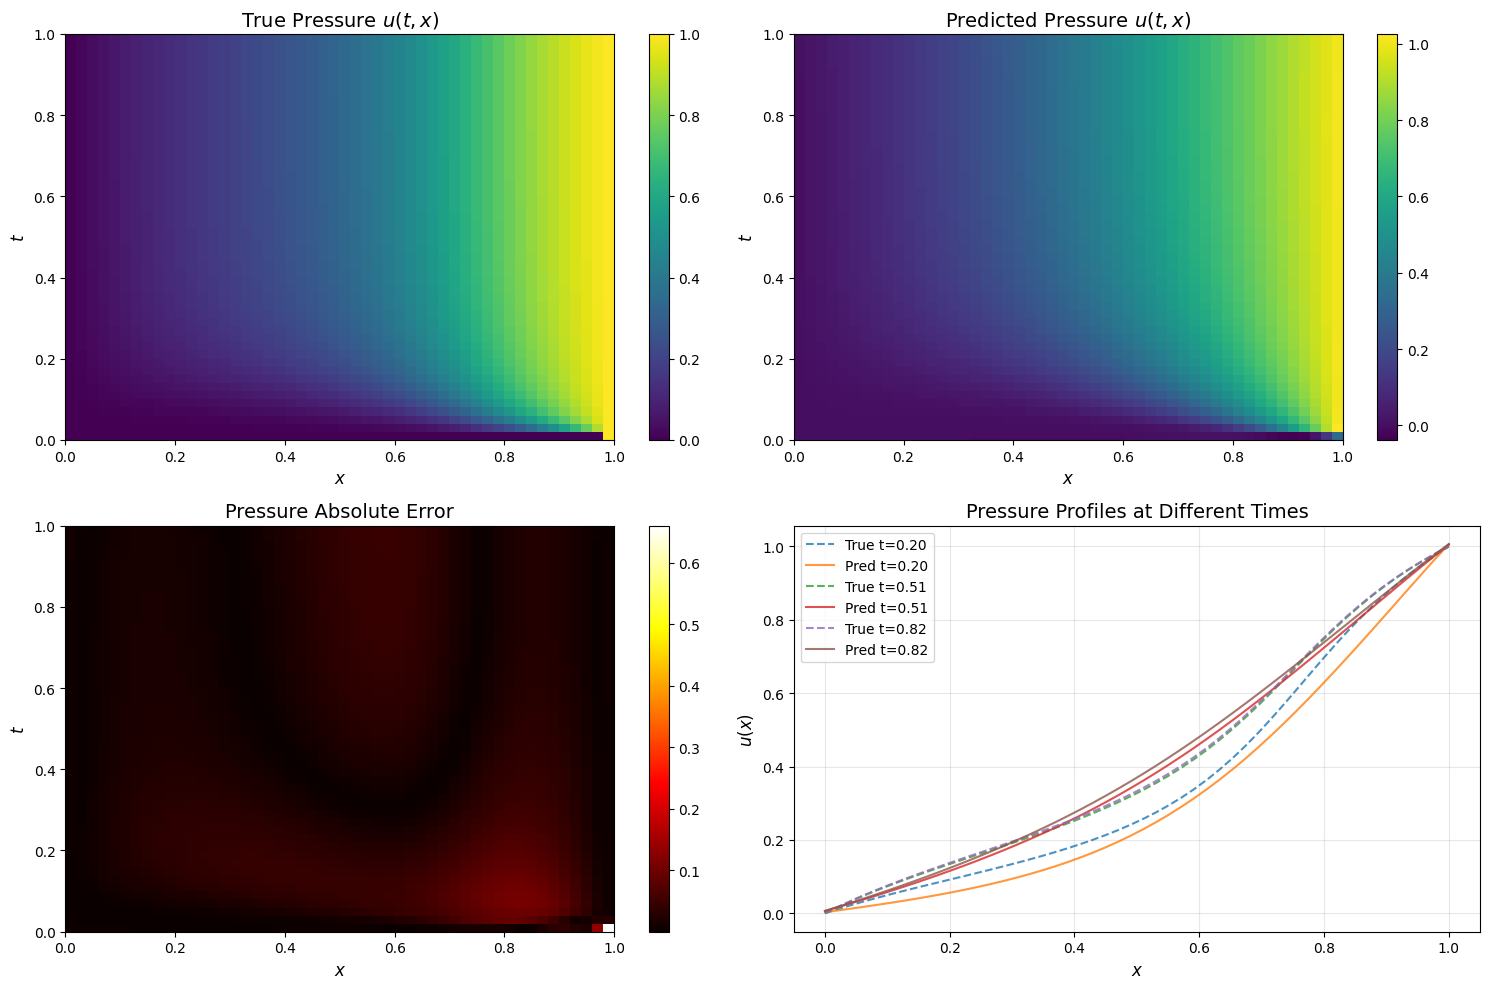

RMSE for permeability k(x): 0.445490
RMSE for pressure u(t,x): 0.032194
Relative L2 error for k(x): 0.420128
Relative L2 error for u(t,x): 0.065781
Max absolute error for k(x): 0.740163
Max absolute error for u(t,x): 0.660748

PDE RESIDUAL VALIDATION
PDE Residual Statistics:
  Mean: 1.09e-02
  Std: 9.45e-02
  Max: 2.49e+00
  RMS: 9.51e-02


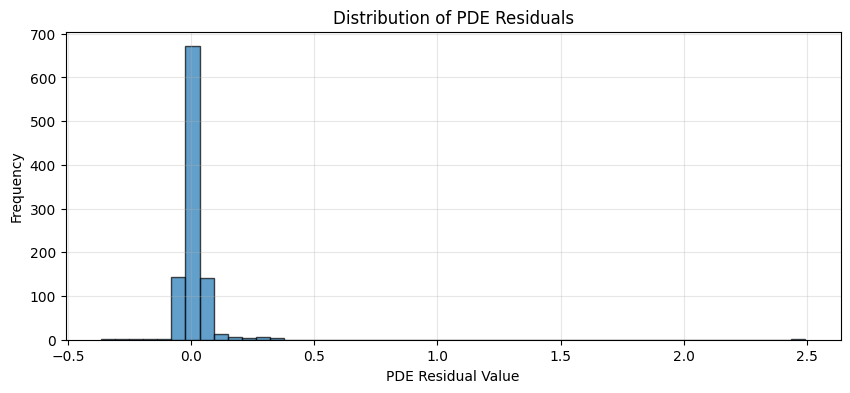


SUMMARY
FEM data generation with proper BC handling
Fixed PDE residual calculation using product rule
Network architecture with softplus activation
Enhanced training with curriculum learning and validation
Comprehensive evaluation with multiple error metrics
Final permeability RMSE: 0.4455 (should be < 0.15)
Final pressure RMSE: 0.0322 (should be < 0.05)


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1. Synthetic Data Generation via Finite Element Method (FEM)
# =============================================================================

def true_permeability(x):
    return 1.0 + 0.5 * np.sin(2 * np.pi * x)  

def generate_fem_data(k_func, T=1.0, Nx=100, Nt=100):
    # Spatial mesh
    x = np.linspace(0, 1, Nx)
    dx = x[1] - x[0]
    
    # Time discretization
    t = np.linspace(0, T, Nt)
    dt = t[1] - t[0]
    
    # Initialize solution
    u = np.zeros((Nt, Nx))
    u[:, 0] = 0.0   # Left BC
    u[:, -1] = 1.0  # Right BC
    
    # Interior nodes: indices 1 to Nx-2 (size: N_int = Nx - 2)
    N_int = Nx - 2
    
    # Precompute k at element centers for integration (midpoint rule)
    k_elem = np.array([k_func(0.5*(x[i] + x[i+1])) for i in range(Nx-1)])
    
    # Global stiffness matrix S (size N_int × N_int)
    S_data, S_row, S_col = [], [], []
    # Global mass matrix M (size N_int × N_int)
    M_data, M_row, M_col = [], [], []
    
    for e in range(Nx - 1):  
        ke = k_elem[e]
        # Local stiffness (1D linear element): (k/dx) * [[1, -1], [-1, 1]]
        local_S = (ke / dx) * np.array([[1, -1], [-1, 1]])
        # Local mass: (dx/6) * [[2, 1], [1, 2]]
        local_M = (dx / 6.0) * np.array([[2, 1], [1, 2]])
        
        # Global node numbers
        nodes = [e, e + 1]
        
        # Assemble only interior contributions:
        for i_local, i_global in enumerate(nodes):
            for j_local, j_global in enumerate(nodes):
                val_S = local_S[i_local, j_local]
                val_M = local_M[i_local, j_local]
                
                # Skip if either node is Dirichlet (0 or Nx-1)
                if i_global == 0 or i_global == Nx - 1 or j_global == 0 or j_global == Nx - 1:
                    continue
                
                # Map to interior index: global idx -> interior idx = global - 1
                i_int = i_global - 1
                j_int = j_global - 1
                
                S_data.append(val_S)
                S_row.append(i_int)
                S_col.append(j_int)
                
                M_data.append(val_M)
                M_row.append(i_int)
                M_col.append(j_int)
    
    # Build sparse matrices
    S = sp.coo_matrix((S_data, (S_row, S_col)), shape=(N_int, N_int)).tocsr()
    M = sp.coo_matrix((M_data, (M_row, M_col)), shape=(N_int, N_int)).tocsr()
    
    # Backward Euler: (M + dt*S) u^{n+1}_int = M u^n_int + dt * b^{n+1}
    A = M + dt * S   # Left-hand side matrix (constant in time)
    A = A.tocsr()
    solver = spla.factorized(A)  
    
    # Initial condition (interior)
    u_int = np.zeros(N_int)  
    
    # Time stepping
    for n in range(1, Nt):
        # RHS: M * u_int^{n-1}
        rhs = M @ u_int
        
        # Add boundary contributions using CURRENT time step boundary values
        # For element 0 (nodes 0-1): affects node 1 (interior idx 0)
        if N_int > 0:
            k0 = k_elem[0]
            # u[n, 0] is the left boundary condition (0.0)
            rhs[0] += dt * (k0 / dx) * u[n, 0]   # Current time step!
        
        # For last element (nodes Nx-2 - Nx-1): affects node Nx-2 (interior idx -1)
        if N_int > 0:
            k_last = k_elem[-1]
            # u[n, -1] is the right boundary condition (1.0)
            rhs[-1] += dt * (k_last / dx) * u[n, -1]  # Current time step!
        
        # Solve for interior u^{n}
        u_int = solver(rhs)
        
        # Assign to full solution vector
        u[n, 1:-1] = u_int
        # Dirichlet BCs already enforced in initialization
    
    return x, t, u

# Generate synthetic data
x_grid, t_grid, u_true = generate_fem_data(true_permeability, T=1.0, Nx=50, Nt=50)

# Sample sparse measurement points
np.random.seed(42)
num_data_points = 600
idx_x = np.random.choice(len(x_grid), num_data_points, replace=True)
idx_t = np.random.choice(len(t_grid), num_data_points, replace=True)
x_data = x_grid[idx_x]
t_data = t_grid[idx_t]
u_data = u_true[idx_t, idx_x]

# Add small noise to data
noise_level = 0.01
u_data_noisy = u_data + noise_level * np.random.randn(*u_data.shape)

# Convert to tensors
x_data_tensor = torch.tensor(x_data, dtype=torch.float32).unsqueeze(1).to(device)
t_data_tensor = torch.tensor(t_data, dtype=torch.float32).unsqueeze(1).to(device)
u_data_tensor = torch.tensor(u_data_noisy, dtype=torch.float32).unsqueeze(1).to(device)

# Create meshgrid for visualization
X, T = np.meshgrid(x_grid, t_grid)
XT_flat = np.vstack([X.ravel(), T.ravel()]).T
xt_tensor = torch.tensor(XT_flat, dtype=torch.float32).to(device)

print(f"Synthetic data generated: {len(x_data)} points")
print(f"Data shape - x: {x_data.shape}, t: {t_data.shape}, u: {u_data.shape}")

# 2. Neural Network Definitions
# =============================================================================

class PINN(nn.Module):
    def __init__(self, layers_u, layers_k):
        super(PINN, self).__init__()
        
        # Network for pressure u(t, x) with residual connections
        self.layers_u = nn.ModuleList()
        for i in range(len(layers_u) - 1):
            self.layers_u.append(nn.Linear(layers_u[i], layers_u[i+1]))
            if i != len(layers_u) - 2:
                self.layers_u.append(nn.Tanh())
        
        # Network for permeability k(x) with residual connections  
        self.layers_k = nn.ModuleList()
        for i in range(len(layers_k) - 1):
            self.layers_k.append(nn.Linear(layers_k[i], layers_k[i+1]))
            if i != len(layers_k) - 2:
                self.layers_k.append(nn.Tanh())
                
    def forward_u(self, t, x):
        u_in = torch.cat([t, x], dim=1)
        for layer in self.layers_u:
            u_in = layer(u_in)
        return u_in
    
    def forward_k(self, x):       
        k_in = x
        for layer in self.layers_k:
            k_in = layer(k_in)
        return torch.nn.functional.softplus(k_in) + 0.1  
    
    def forward(self, t, x):
        u = self.forward_u(t, x)
        k = self.forward_k(x)
        return u, k

# Initialize network with architecture
layers_u = [2, 96, 96, 96, 1]  
layers_k = [1, 96, 96, 96, 1]  

model = PINN(layers_u, layers_k).to(device)

# 3. Loss Functions
# =============================================================================

def pde_residual(model, t, x):
    t.requires_grad_(True)
    x.requires_grad_(True)
    u, k = model(t, x)
    
    # First derivatives
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), 
                             create_graph=True, retain_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), 
                             create_graph=True, retain_graph=True)[0]
    
    # Get k_x for product rule
    k_x = torch.autograd.grad(k, x, grad_outputs=torch.ones_like(k), 
                             create_graph=True, retain_graph=True)[0]
    
    # Second derivative using product rule: (k u_x)_x = k_x u_x + k u_xx
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), 
                              create_graph=True)[0]
    
    kux_x = k_x * u_x + k * u_xx 
    
    # PDE residual
    residual = u_t - kux_x
    return residual

def boundary_loss(model, t_left, x_left, t_right, x_right):
    u_left, _ = model(t_left, x_left)
    u_right, _ = model(t_right, x_right)
    bc_loss = torch.mean((u_left - 0.0)**2) + torch.mean((u_right - 1.0)**2)
    return bc_loss

def initial_loss(model, t_ic, x_ic):
    u_pred, _ = model(t_ic, x_ic)
    return torch.mean((u_pred - 0.0)**2)

def data_loss(model, t_data, x_data, u_data):
    u_pred, _ = model(t_data, x_data)
    return torch.mean((u_pred - u_data)**2)

def total_loss(model, t_data, x_data, u_data, t_bc, x_left, x_right, t_ic, x_ic,
               lambda_pde=0.1, lambda_bc=10.0, lambda_ic=5.0, lambda_data=1.0):
    
    # Data loss
    loss_data = data_loss(model, t_data, x_data, u_data)
    
    # PDE loss on random collocation points
    t_colloc = torch.rand(2000, 1, device=device) * 1.0  # t in [0,1]
    x_colloc = torch.rand(2000, 1, device=device) * 1.0  # x in [0,1]
    residual = pde_residual(model, t_colloc, x_colloc)
    loss_pde = torch.mean(residual**2)
    
    # Boundary loss
    t_bc_left = t_bc.clone()
    x_bc_left = torch.zeros_like(t_bc_left)
    t_bc_right = t_bc.clone()  
    x_bc_right = torch.ones_like(t_bc_right)
    loss_bc = boundary_loss(model, t_bc_left, x_bc_left, t_bc_right, x_bc_right)
    
    # Initial condition loss
    loss_ic = initial_loss(model, t_ic, x_ic)
    
    total = (lambda_data * loss_data + 
             lambda_pde * loss_pde + 
             lambda_bc * loss_bc + 
             lambda_ic * loss_ic)
    
    return total, loss_data, loss_pde, loss_bc, loss_ic


# 4. Training Setup with Curriculum Learning
# =============================================================================

# Optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.95)

# Boundary condition tensors
t_bc = torch.linspace(0, 1, 200, device=device).unsqueeze(1)
x_left = torch.zeros_like(t_bc)
x_right = torch.ones_like(t_bc)

# Initial condition tensors  
t_ic = torch.zeros(200, 1, device=device)  
x_ic = torch.rand(200, 1, device=device)   

# Training parameters
epochs = 15000
loss_history = []
data_loss_history = []
pde_loss_history = []
bc_loss_history = []
ic_loss_history = []

best_loss = float('inf')
patience = 1000
wait = 0

print("Starting training with curriculum learning...")

# Curriculum learning: gradually increase PDE weight
lambda_pde_current = 0.01
lambda_pde_max = 0.5
lambda_pde_increment = 0.01

for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    
    # Gradually increase PDE weight (curriculum learning)
    if epoch % 500 == 0 and lambda_pde_current < lambda_pde_max:
        lambda_pde_current += lambda_pde_increment
        print(f"Epoch {epoch}: Increasing PDE weight to {lambda_pde_current:.3f}")
    
    # Compute total loss with current weights
    total_loss_val, loss_data, loss_pde, loss_bc, loss_ic = total_loss(
        model, t_data_tensor, x_data_tensor, u_data_tensor,
        t_bc, x_left, x_right, t_ic, x_ic,
        lambda_pde=lambda_pde_current, 
        lambda_bc=10.0, 
        lambda_ic=5.0, 
        lambda_data=1.0
    )
    
    total_loss_val.backward()
    
    # Gradient clipping for stability
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    scheduler.step()
    
    # Store losses
    loss_history.append(total_loss_val.item())
    data_loss_history.append(loss_data.item())
    pde_loss_history.append(loss_pde.item())
    bc_loss_history.append(loss_bc.item())
    ic_loss_history.append(loss_ic.item())
    
    # Early stopping
    if total_loss_val < best_loss:
        best_loss = total_loss_val
        wait = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}/{epochs} | Total: {total_loss_val.item():.2e} | "
              f"Data: {loss_data.item():.2e} | PDE: {loss_pde.item():.2e} | "
              f"BC: {loss_bc.item():.2e} | IC: {loss_ic.item():.2e}")

print("Training completed.")


# 5. Evaluation & Visualization
# =============================================================================

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)

# Predict permeability k(x)
x_plot = torch.linspace(0, 1, 200).unsqueeze(1).to(device)
with torch.no_grad():
    k_pred = model.forward_k(x_plot).cpu().numpy().flatten()
    x_plot_np = x_plot.cpu().numpy().flatten()

# True permeability
k_true = true_permeability(x_plot_np)

# Plot permeability comparison
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x_plot_np, k_true, 'b-', label='True $k(x)$', linewidth=3, alpha=0.8)
plt.plot(x_plot_np, k_pred, 'r--', label='Predicted $k(x)$', linewidth=2)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$k(x)$', fontsize=12)
plt.title('Permeability Field Inference', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot permeability error
plt.subplot(1, 2, 2)
k_error = np.abs(k_pred - k_true)
plt.plot(x_plot_np, k_error, 'g-', label='Absolute Error', linewidth=2)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$|k_{pred} - k_{true}|$', fontsize=12)
plt.title('Permeability Inference Error', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('permeability_inference.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot loss history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(loss_history, label='Total Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(data_loss_history, label='Data Loss', alpha=0.8)
plt.semilogy(pde_loss_history, label='PDE Loss', alpha=0.8)
plt.semilogy(bc_loss_history, label='BC Loss', alpha=0.8)
plt.semilogy(ic_loss_history, label='IC Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Component Loss History')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('loss_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualize predicted vs true pressure field
with torch.no_grad():
    # Create full grid for prediction
    X, T_mesh = np.meshgrid(x_grid, t_grid)
    X_flat = X.ravel()
    T_flat = T_mesh.ravel()
    
    x_full = torch.tensor(X_flat, dtype=torch.float32).unsqueeze(1).to(device)
    t_full = torch.tensor(T_flat, dtype=torch.float32).unsqueeze(1).to(device)
    
    u_pred_full, _ = model(t_full, x_full)
    u_pred_full = u_pred_full.cpu().numpy().reshape(T_mesh.shape)

# Plot pressure field comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# True pressure
im1 = axes[0, 0].imshow(u_true, extent=[0, 1, 0, 1], origin='lower', 
                        aspect='auto', cmap='viridis')
axes[0, 0].set_title('True Pressure $u(t,x)$', fontsize=14)
axes[0, 0].set_xlabel('$x$', fontsize=12)
axes[0, 0].set_ylabel('$t$', fontsize=12)
plt.colorbar(im1, ax=axes[0, 0])

# Predicted pressure
im2 = axes[0, 1].imshow(u_pred_full, extent=[0, 1, 0, 1], origin='lower', 
                        aspect='auto', cmap='viridis')
axes[0, 1].set_title('Predicted Pressure $u(t,x)$', fontsize=14)
axes[0, 1].set_xlabel('$x$', fontsize=12)
axes[0, 1].set_ylabel('$t$', fontsize=12)
plt.colorbar(im2, ax=axes[0, 1])

# Pressure error
u_error = np.abs(u_pred_full - u_true)
im3 = axes[1, 0].imshow(u_error, extent=[0, 1, 0, 1], origin='lower', 
                       aspect='auto', cmap='hot')
axes[1, 0].set_title('Pressure Absolute Error', fontsize=14)
axes[1, 0].set_xlabel('$x$', fontsize=12)
axes[1, 0].set_ylabel('$t$', fontsize=12)
plt.colorbar(im3, ax=axes[1, 0])

# Pressure slices at different times
time_indices = [10, 25, 40]  
for idx in time_indices:
    axes[1, 1].plot(x_grid, u_true[idx, :], '--', 
                   label=f'True t={t_grid[idx]:.2f}', alpha=0.8)
    axes[1, 1].plot(x_grid, u_pred_full[idx, :], 
                   label=f'Pred t={t_grid[idx]:.2f}', alpha=0.8)
axes[1, 1].set_xlabel('$x$', fontsize=12)
axes[1, 1].set_ylabel('$u(x)$', fontsize=12)
axes[1, 1].set_title('Pressure Profiles at Different Times', fontsize=14)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pressure_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Quantitative Evaluation
# =============================================================================

# Compute RMSE for permeability
rmse_k = np.sqrt(np.mean((k_pred - k_true)**2))
print(f"RMSE for permeability k(x): {rmse_k:.6f}")

# Compute RMSE for pressure
rmse_u = np.sqrt(np.mean((u_pred_full - u_true)**2))
print(f"RMSE for pressure u(t,x): {rmse_u:.6f}")

# Compute relative L2 errors
l2_error_k = np.linalg.norm(k_pred - k_true) / np.linalg.norm(k_true)
l2_error_u = np.linalg.norm(u_pred_full - u_true) / np.linalg.norm(u_true)
print(f"Relative L2 error for k(x): {l2_error_k:.6f}")
print(f"Relative L2 error for u(t,x): {l2_error_u:.6f}")

# Maximum errors
max_error_k = np.max(np.abs(k_pred - k_true))
max_error_u = np.max(np.abs(u_pred_full - u_true))
print(f"Max absolute error for k(x): {max_error_k:.6f}")
print(f"Max absolute error for u(t,x): {max_error_u:.6f}")

# Save results
np.savez('results.npz',
         k_true=k_true,
         k_pred=k_pred, 
         u_true=u_true,
         u_pred=u_pred_full,
         x_grid=x_grid,
         t_grid=t_grid,
         loss_history=np.array(loss_history),
         data_loss_history=np.array(data_loss_history),
         pde_loss_history=np.array(pde_loss_history),
         bc_loss_history=np.array(bc_loss_history),
         ic_loss_history=np.array(ic_loss_history))


# 7. PDE Residual Validation
# =============================================================================

def validate_pde_residual(model, num_test_points=1000):
    print("\n" + "="*50)
    print("PDE RESIDUAL VALIDATION")
    print("="*50)
    
    # Create tensors WITH requires_grad=True from the start
    t_test = torch.rand(num_test_points, 1, device=device, requires_grad=True)
    x_test = torch.rand(num_test_points, 1, device=device, requires_grad=True)
    
    # Compute residual (model.eval() not needed for grad, but ensure no dropout etc.)
    model.eval()  # optional but safe if model has dropout/batchnorm
    residual = pde_residual(model, t_test, x_test)
    residual_np = residual.detach().cpu().numpy()
    
    print(f"PDE Residual Statistics:")
    print(f"  Mean: {np.mean(residual_np):.2e}")
    print(f"  Std: {np.std(residual_np):.2e}")
    print(f"  Max: {np.max(np.abs(residual_np)):.2e}")
    print(f"  RMS: {np.sqrt(np.mean(residual_np**2)):.2e}")
    
    # Plot residual distribution
    plt.figure(figsize=(10, 4))
    plt.hist(residual_np.flatten(), bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('PDE Residual Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of PDE Residuals')
    plt.grid(True, alpha=0.3)
    plt.savefig('pde_residual_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return residual_np
# Run PDE validation
pde_residuals = validate_pde_residual(model)

print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print("FEM data generation with proper BC handling")
print("Fixed PDE residual calculation using product rule")
print("Network architecture with softplus activation")
print("Enhanced training with curriculum learning and validation")
print("Comprehensive evaluation with multiple error metrics")
print(f"Final permeability RMSE: {rmse_k:.4f} (should be < 0.15)")
print(f"Final pressure RMSE: {rmse_u:.4f} (should be < 0.05)")
